In [1]:
%reset -f
import numpy as np
import pandas as pd
import math

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

2022-11-18 12:38:22.380992: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 12:38:22.456574: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-18 12:38:22.459880: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-18 12:38:22.459888: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
feature_names = ['symboling', 'normalized-losses', 'make', 'fuel-type',
                'aspiration', 'num-doors', 'body-style', 'drive-wheels',
                'engine-location', 'wheel-base', 'length', 'width', 'height', 'weight',
                'engine-tpe', 'num-cylinders', 'engine-size', 'fuel-system', 'bore',
                'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
                'highway-mpg', 'price']

car_data = pd.read_csv('https://storage.googleapis.com/mledu-datasets/cars_data.csv',
                      sep=',', names=feature_names, header=None, encoding='latin-1')

car_data.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.60,...,130,mpfi,3.47,2.68,9.00,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.60,...,130,mpfi,3.47,2.68,9.00,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.50,...,152,mpfi,2.68,3.47,9.00,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.80,...,109,mpfi,3.19,3.40,10.00,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.40,...,136,mpfi,3.19,3.40,8.00,115,5500,18,22,17450


In [3]:
car_data = car_data.reindex(np.random.permutation(car_data.index))
print("Number of examples: ", len(car_data))
car_data.head()

Number of examples:  205


,symboling,normalized-losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
171,2,134,toyota,gas,std,two,hatchback,rwd,front,98.40,...,146,mpfi,3.62,3.50,9.30,116,4800,24,30,11549
75,1,?,mercury,gas,turbo,two,hatchback,rwd,front,102.70,...,140,mpfi,3.78,3.12,8.00,175,5000,19,24,16503
24,1,148,dodge,gas,std,four,hatchback,fwd,front,93.70,...,90,2bbl,2.97,3.23,9.40,68,5500,31,38,6229
18,2,121,chevrolet,gas,std,two,hatchback,fwd,front,88.40,...,61,2bbl,2.91,3.03,9.50,48,5100,47,53,5151
191,0,?,volkswagen,gas,std,four,sedan,fwd,front,100.40,...,136,mpfi,3.19,3.40,8.50,110,5500,19,24,13295


## Task 0: Use pandas to explore and prepare the data

- Use pandas to inspect the data and manually curate a list of numeric_feature_names and catagorical_feature_names

#### Useful functions
 - `type()` called on any python object describes the type of that object
 - `dataframe[4:7]` pulls out rows 4,5,6 in a pandas dataframe
 - `dataframe[['mycol1', 'mycol2']]` pulls out two requested columns into a new pandas dataframe
 - `dataframe['mycol1']` returns a pandas series - not a dataframe
 - `dataframe.describe()` prints out statistics for each dataframe column

In [4]:
car_data[4:7]

,symboling,normalized-losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
191,0,?,volkswagen,gas,std,four,sedan,fwd,front,100.40,...,136,mpfi,3.19,3.40,8.50,110,5500,19,24,13295
141,0,102,subaru,gas,std,four,sedan,fwd,front,97.20,...,108,2bbl,3.62,2.64,9.50,82,4800,32,37,7126
170,2,134,toyota,gas,std,two,hardtop,rwd,front,98.40,...,146,mpfi,3.62,3.50,9.30,116,4800,24,30,11199


In [5]:
LABEL = 'price'

numeric_feature_names = car_data[['symboling','normalized-losses','wheel-base','engine-size','bore',
                                  'stroke','compression-ratio','horsepower','peak-rpm','city-mpg',
                                  'highway-mpg','price']]

categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))

assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

AssertionError: 

In [6]:
numeric_feature_names = ['symboling', 'normalized-losses', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-size', 'horsepower',
        'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke',
         'compression-ratio']

categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))

assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

In [7]:
car_data[numeric_feature_names]

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,horsepower,peak-rpm,city-mpg,highway-mpg,bore,stroke,compression-ratio
171,2,134,98.40,176.20,65.60,52.00,2714,146,116,4800,24,30,3.62,3.50,9.30
75,1,?,102.70,178.40,68.00,54.80,2910,140,175,5000,19,24,3.78,3.12,8.00
24,1,148,93.70,157.30,63.80,50.60,1967,90,68,5500,31,38,2.97,3.23,9.40
18,2,121,88.40,141.10,60.30,53.20,1488,61,48,5100,47,53,2.91,3.03,9.50
191,0,?,100.40,180.20,66.90,55.10,2661,136,110,5500,19,24,3.19,3.40,8.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,2,134,98.40,176.20,65.60,52.00,2540,146,116,4800,24,30,3.62,3.50,9.30
110,0,?,114.20,198.90,68.40,58.70,3430,152,95,4150,25,25,3.70,3.52,21.00
8,1,158,105.80,192.70,71.40,55.90,3086,131,140,5500,17,20,3.13,3.40,8.30
38,0,106,96.50,167.50,65.20,53.30,2289,110,86,5800,27,33,3.15,3.58,9.00


In [8]:
car_data[categorical_feature_names]

,num-cylinders,fuel-type,make,engine-location,num-doors,engine-tpe,aspiration,fuel-system,body-style,drive-wheels
171,four,gas,toyota,front,two,ohc,std,mpfi,hatchback,rwd
75,four,gas,mercury,front,two,ohc,turbo,mpfi,hatchback,rwd
24,four,gas,dodge,front,four,ohc,std,2bbl,hatchback,fwd
18,three,gas,chevrolet,front,two,l,std,2bbl,hatchback,fwd
191,five,gas,volkswagen,front,four,ohc,std,mpfi,sedan,fwd
...,...,...,...,...,...,...,...,...,...,...
167,four,gas,toyota,front,two,ohc,std,mpfi,hardtop,rwd
110,four,diesel,peugot,front,four,l,turbo,idi,wagon,rwd
8,five,gas,audi,front,four,ohc,turbo,mpfi,sedan,fwd
38,four,gas,honda,front,two,ohc,std,1bbl,hatchback,fwd


In [9]:
for feature_name in numeric_feature_names + [LABEL]:
    car_data[feature_name] = pd.to_numeric(car_data[feature_name], errors='coerce')
    
car_data.fillna(0, inplace=True)

## Task 1: Making best model with numeric features and no normalization

Modify the model provided below to achieve the lowest eval loss. You may want to change various hyperparameters:
- learning rate
- choice of optimizer
- hidden layer dimensions
- batch size
- num training steps
- something else

#### Do not use the `normalizer_fn` arg on `numeric_column`

In [10]:
batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(x=x_df, y=y_series, batch_size=batch_size,
                                                    num_epochs=None, shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(x=x_df, y=y_series, batch_size=batch_size, shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(x=x_df, batch_size=batch_size, shuffle=False)


['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']




### Preprocessing

In [11]:
#PREPROCESSING
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name) for feature_name in numeric_feature_names
]
print("Model_feature_columns", model_feature_columns)

est = tf.estimator.DNNRegressor(feature_columns=model_feature_columns,
                               hidden_units=[64],
                               optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
                               )

Model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='horsepower', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='peak-rpm', shape=(1,), default_value=None

### Train

In [12]:
# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
    est.train(train_input_fn, steps=num_training_steps // num_print_statements)
    scores = est.evaluate(eval_input_fn)
    
    print("Scores", scores)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpr7stk7ef/model.ckpt.


2022-11-18 12:38:33.232409: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 12:38:33.233125: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-18 12:38:33.233144: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-18 12:38:33.233155: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nsl54): /proc/driver/nvidia/version does not exist
2022-11-18 12:38:33.236572: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR 

INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 3155257000.0, step = 1
INFO:tensorflow:global_step/sec: 1093.9
INFO:tensorflow:loss = 710796100.0, step = 101 (0.093 sec)
INFO:tensorflow:global_step/sec: 1031.82
INFO:tensorflow:loss = 2242114300.0, step = 201 (0.097 sec)
INFO:tensorflow:global_step/sec: 1054.82
INFO:tensorflow:loss = 608712960.0, step = 301 (0.095 sec)
INFO:tensorflow:global_step/sec: 1039.24
INFO:tensorflow:loss = 546548200.0, step = 401 (0.096 sec)
INFO:tensorflow:global_step/sec: 1046.32
INFO:tensorflow:loss = 920458600.0, step = 501 (0.095 sec)
INFO:tensorflow:global_step/sec: 1052.11
INFO:tensorflow:loss = 736726460.0, step = 601 (0.095 sec)
INFO:tensorflow:global_step/sec: 1048.52
INFO:tensorflow:loss = 230593900.0, step = 701 (0.096 sec)
INFO:tensorflow:global_step/sec: 1054.57
INFO:tensorflow:loss = 755230300.0, step = 801 (0.094 sec)
INFO:tensorflow:global_step/sec: 1054.08
INFO:tensorflow:loss = 876545860.0, ste

INFO:tensorflow:loss = 560208600.0, step = 3001
INFO:tensorflow:global_step/sec: 882.807
INFO:tensorflow:loss = 307939000.0, step = 3101 (0.115 sec)
INFO:tensorflow:global_step/sec: 1032.46
INFO:tensorflow:loss = 250390780.0, step = 3201 (0.097 sec)
INFO:tensorflow:global_step/sec: 1029.9
INFO:tensorflow:loss = 524823940.0, step = 3301 (0.097 sec)
INFO:tensorflow:global_step/sec: 1044.54
INFO:tensorflow:loss = 499336320.0, step = 3401 (0.097 sec)
INFO:tensorflow:global_step/sec: 1023.39
INFO:tensorflow:loss = 441574240.0, step = 3501 (0.097 sec)
INFO:tensorflow:global_step/sec: 1062.06
INFO:tensorflow:loss = 672151200.0, step = 3601 (0.095 sec)
INFO:tensorflow:global_step/sec: 1055.23
INFO:tensorflow:loss = 275261730.0, step = 3701 (0.095 sec)
INFO:tensorflow:global_step/sec: 1014.93
INFO:tensorflow:loss = 130675310.0, step = 3801 (0.098 sec)
INFO:tensorflow:global_step/sec: 1057.8
INFO:tensorflow:loss = 138185000.0, step = 3901 (0.095 sec)
INFO:tensorflow:Calling checkpoint listeners 

INFO:tensorflow:global_step/sec: 865.974
INFO:tensorflow:loss = 94226350.0, step = 6101 (0.117 sec)
INFO:tensorflow:global_step/sec: 1054.22
INFO:tensorflow:loss = 263248510.0, step = 6201 (0.094 sec)
INFO:tensorflow:global_step/sec: 1070.24
INFO:tensorflow:loss = 586617540.0, step = 6301 (0.093 sec)
INFO:tensorflow:global_step/sec: 1051.57
INFO:tensorflow:loss = 315313820.0, step = 6401 (0.095 sec)
INFO:tensorflow:global_step/sec: 1036.14
INFO:tensorflow:loss = 498117340.0, step = 6501 (0.097 sec)
INFO:tensorflow:global_step/sec: 1061.95
INFO:tensorflow:loss = 112575810.0, step = 6601 (0.094 sec)
INFO:tensorflow:global_step/sec: 1057.72
INFO:tensorflow:loss = 515433400.0, step = 6701 (0.094 sec)
INFO:tensorflow:global_step/sec: 1057.07
INFO:tensorflow:loss = 151396420.0, step = 6801 (0.094 sec)
INFO:tensorflow:global_step/sec: 1057.26
INFO:tensorflow:loss = 151943310.0, step = 6901 (0.095 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 7000...
INFO:tensorflo

INFO:tensorflow:global_step/sec: 1014.71
INFO:tensorflow:loss = 386216670.0, step = 9501 (0.097 sec)
INFO:tensorflow:global_step/sec: 1025.01
INFO:tensorflow:loss = 300239330.0, step = 9601 (0.098 sec)
INFO:tensorflow:global_step/sec: 1009.95
INFO:tensorflow:loss = 140542900.0, step = 9701 (0.099 sec)
INFO:tensorflow:global_step/sec: 1021.76
INFO:tensorflow:loss = 1059586200.0, step = 9801 (0.098 sec)
INFO:tensorflow:global_step/sec: 1023.53
INFO:tensorflow:loss = 466977820.0, step = 9901 (0.098 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 10000...
INFO:tensorflow:Saving checkpoints for 10000 into /tmp/tmpr7stk7ef/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 10000...
INFO:tensorflow:Loss for final step: 245630080.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-11-18T12:38:50
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters fr

## Visualization

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpr7stk7ef/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


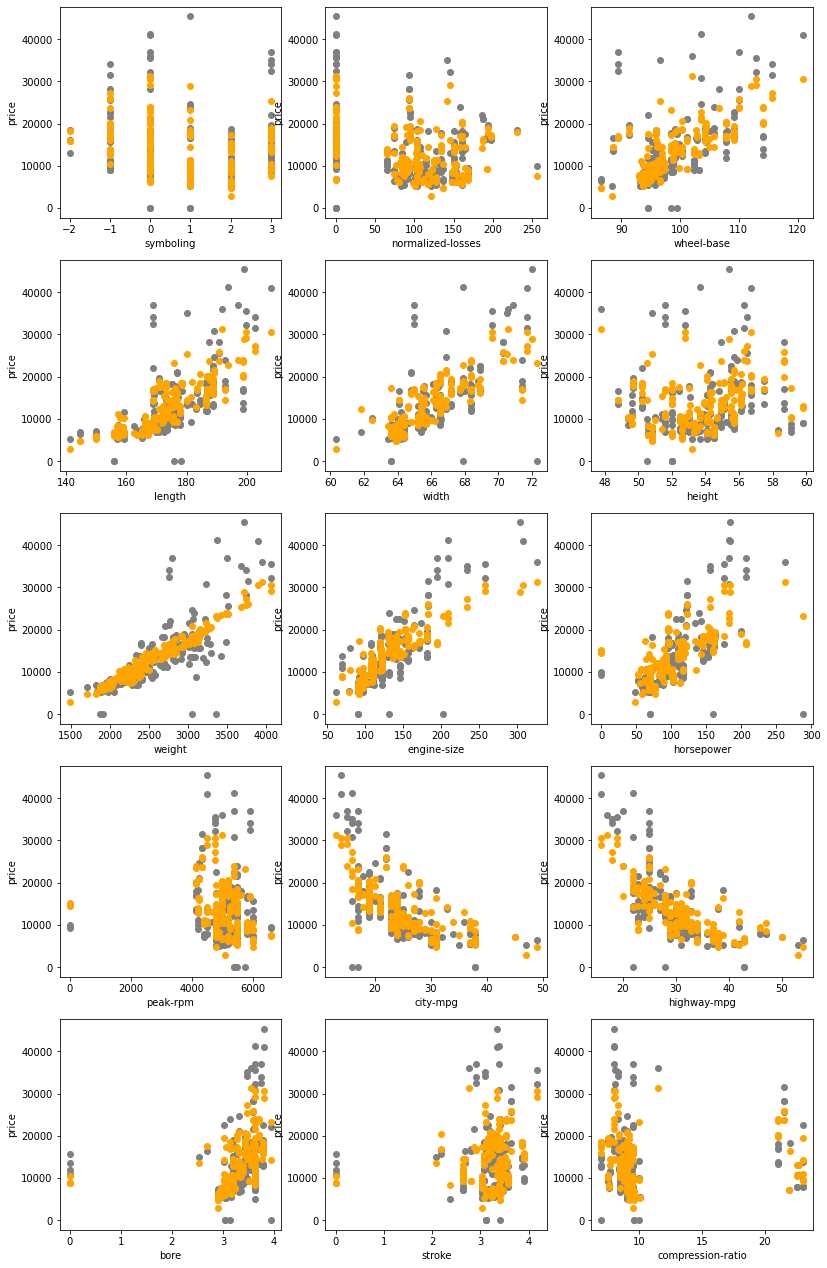

In [13]:
from matplotlib import pyplot as plt

def scatter_plot_inference_grid(est, x_df, feature_names):
    
    def scatter_plot_inference(axis,
                              x_axis_feature_name,
                              y_axis_feature_name,
                              predictions):
        
        y_axis_feature_name = 'price'
        axis.set_ylabel(y_axis_feature_name)
        axis.set_xlabel(x_axis_feature_name)
        axis.scatter(car_data[x_axis_feature_name],
                    car_data[y_axis_feature_name],
                    c='grey')
        
        axis.scatter(car_data[x_axis_feature_name], predictions, c='orange')
    
    predict_input_fn = tf.estimator.inputs.pandas_input_fn(x=x_df, batch_size=batch_size, shuffle=False)
    
    predictions = [
        x['predictions'][0]
        for x in est.predict(predict_input_fn)
    ]
    
    num_cols = 3
    num_rows = int(math.ceil(len(feature_names)/float(num_cols)))
    f, axarr = plt.subplots(num_rows, num_cols)
    size = 4.5
    f.set_size_inches(num_cols*size, num_rows*size)
    
    for i, feature_name in enumerate(numeric_feature_names):
        axis = axarr[int(i/num_cols), i%num_cols]
        scatter_plot_inference(axis, feature_name, 'price', predictions)
    plt.show()
    
scatter_plot_inference_grid(est, x_df, numeric_feature_names)

## Task 2: Take best numeric model and add normalization
- Decide what type of normalization to add, and for which features
- Use the normalizer_fn arg on `numeric_column`
<br>
&emsp; example: normalizer_fn = lambda x: tf.neg(tf.subtract(x,1)) shifts inputs down by 1, and then negates the value
<br>
- Helpful pandas functions:
  - `dataframe.mean()['feature_name']`
  - `dataframe.std()['feature_name']`


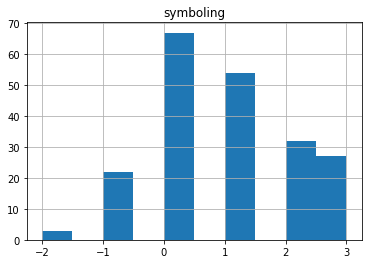

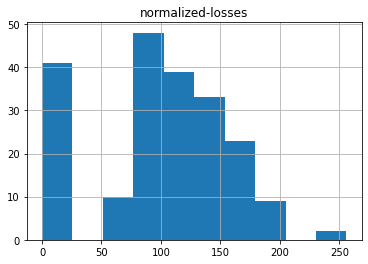

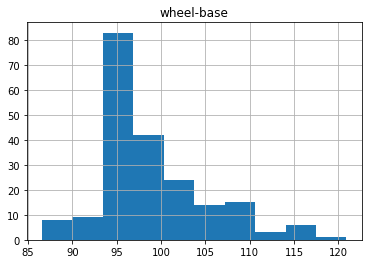

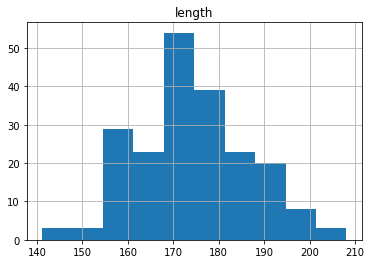

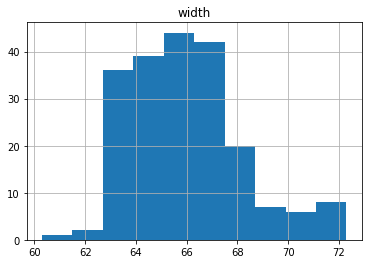

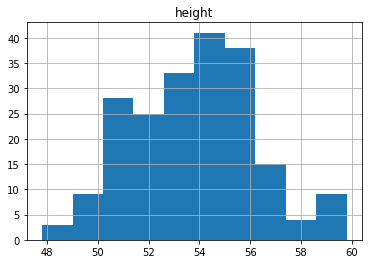

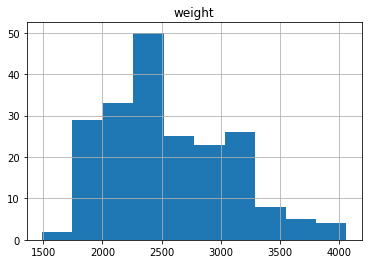

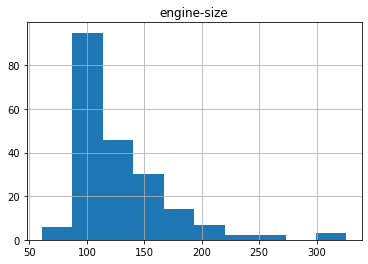

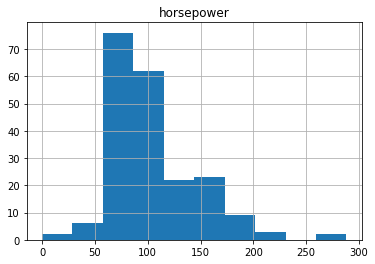

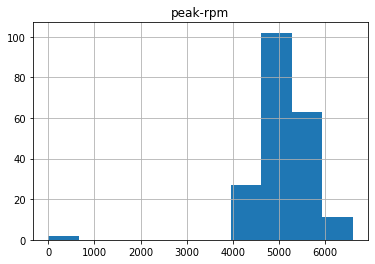

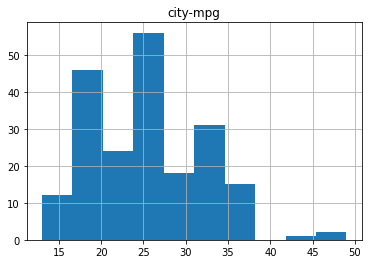

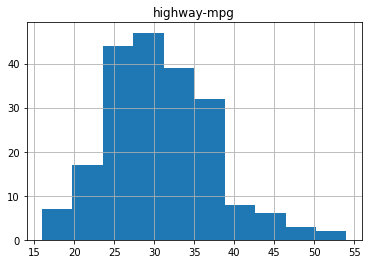

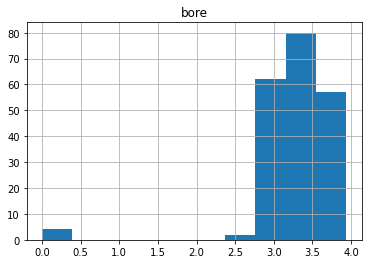

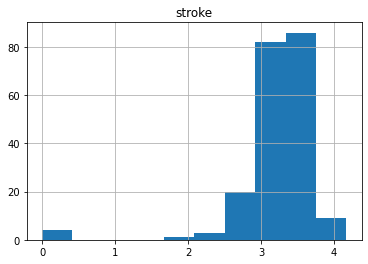

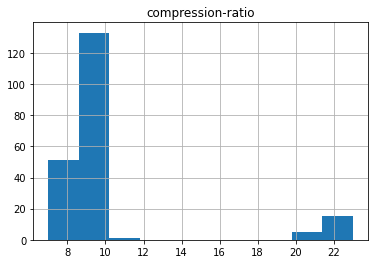

In [14]:
for feature_name in numeric_feature_names:
    car_data.hist(column=feature_name)

['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']
Model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f447c739730>), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f43fda43bf8>), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f43fdb56f28>), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f43fdbff7b8>), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f44242f2158>), NumericColumn(key='height', shape=(1,), default_va

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpqqai7pwx/model.ckpt-2000
Scores {'average_loss': 48503310.0, 'label/mean': 12949.43, 'loss': 764859970.0, 'prediction/mean': 13303.862, 'global_step': 2000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpqqai7pwx/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 2000...
INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpqqai7pwx/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 2000...
INFO:tensorflow:loss = 281603200.0, step = 2001
INFO:tensorflow:global_step/sec: 806.963
INFO:tensorflow:loss = 648351900.0, step = 2101 (0.125 sec)
INFO:tensorflow:global_step/sec: 1045.06
INFO:tensorflow:loss = 183593

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpqqai7pwx/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5000...
INFO:tensorflow:Saving checkpoints for 5000 into /tmp/tmpqqai7pwx/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 5000...
INFO:tensorflow:loss = 1278443800.0, step = 5001
INFO:tensorflow:global_step/sec: 834.802
INFO:tensorflow:loss = 1096392100.0, step = 5101 (0.121 sec)
INFO:tensorflow:global_step/sec: 1055.41
INFO:tensorflow:loss = 955470100.0, step = 5201 (0.095 sec)
INFO:tensorflow:global_step/sec: 1059.27
INFO:tensorflow:loss = 559616800.0, step = 5301 (0.095 sec)
INFO:tensorflow:global_step/sec: 1050.17
INFO:tensorflow:loss = 194592640.0, step = 5401 (0.095 sec)
INFO:tensorflow:global_step/sec: 1046.44
INFO:tensorflow:loss = 1123420200.0, step = 5501 (0.095 sec)
INFO:tensorflow:

INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 8000...
INFO:tensorflow:loss = 622720300.0, step = 8001
INFO:tensorflow:global_step/sec: 845.331
INFO:tensorflow:loss = 843212700.0, step = 8101 (0.120 sec)
INFO:tensorflow:global_step/sec: 1056.34
INFO:tensorflow:loss = 353969340.0, step = 8201 (0.094 sec)
INFO:tensorflow:global_step/sec: 1051.17
INFO:tensorflow:loss = 477415170.0, step = 8301 (0.096 sec)
INFO:tensorflow:global_step/sec: 1040.2
INFO:tensorflow:loss = 649288100.0, step = 8401 (0.096 sec)
INFO:tensorflow:global_step/sec: 1042.65
INFO:tensorflow:loss = 985600300.0, step = 8501 (0.095 sec)
INFO:tensorflow:global_step/sec: 1048.48
INFO:tensorflow:loss = 747202050.0, step = 8601 (0.096 sec)
INFO:tensorflow:global_step/sec: 1049
INFO:tensorflow:loss = 623470400.0, step = 8701 (0.094 sec)
INFO:tensorflow:global_step/sec: 1034.88
INFO:tensorflow:loss = 851570560.0, step = 8801 (0.097 sec)
INFO:tensorflow:global_step/sec: 1054.88
INFO:tensorflow:loss = 3149858

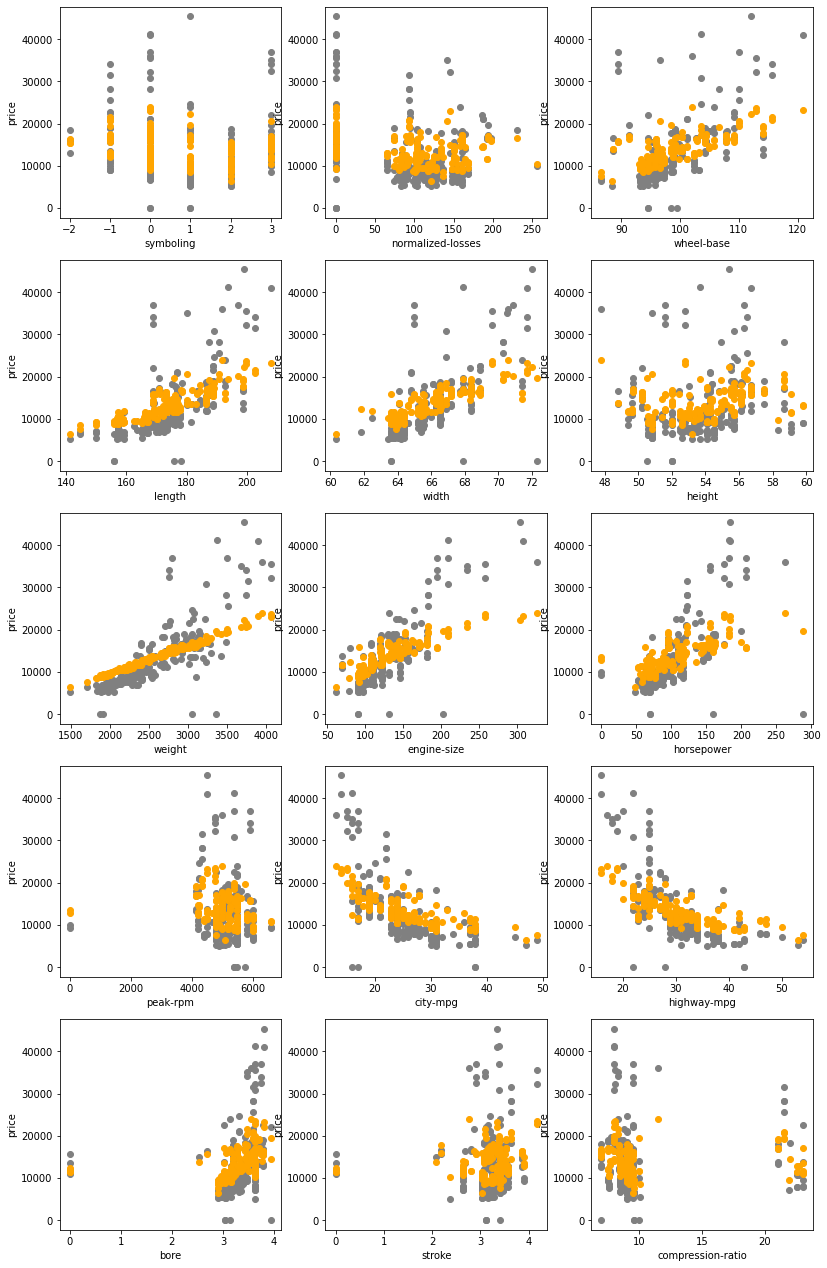

In [15]:
batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(x=x_df, y=y_series, batch_size=batch_size,
                                                    num_epochs=None, shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(x=x_df, y=y_series, batch_size=batch_size, shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(x=x_df, batch_size=batch_size, shuffle=False)

#PREPROCESSING
# Epsilon prevents divide by zero.
epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name,
                                    normalizer_fn=lambda val: (val-x_df.mean()[feature_name])/(epsilon+x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]
print("Model_feature_columns", model_feature_columns)

est = tf.estimator.DNNRegressor(feature_columns=model_feature_columns,
                               hidden_units=[64],
                               optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
                               )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
    est.train(train_input_fn, steps=num_training_steps // num_print_statements)
    scores = est.evaluate(eval_input_fn)
    
    print("Scores", scores)
    
scatter_plot_inference_grid(est, x_df, numeric_feature_names)

## Task 3: Train using only catagorical features
- Look at the possible feature columns for categorical features. They begin with categorical_column_with_ in go/tf-ops
- You may find `dataframe[categorical_feature_names].unique()` helpful.

['num-cylinders', 'fuel-type', 'make', 'engine-location', 'num-doors', 'engine-tpe', 'aspiration', 'fuel-system', 'body-style', 'drive-wheels']
Model_feature_columns [IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='num-cylinders', vocabulary_list=('four', 'three', 'five', 'eight', 'six', 'twelve', 'two'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='fuel-type', vocabulary_list=('gas', 'diesel'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='make', vocabulary_list=('toyota', 'mercury', 'dodge', 'chevrolet', 'volkswagen', 'subaru', 'honda', 'mercedes-benz', 'porsche', 'peugot', 'saab', 'jaguar', 'nissan', 'mitsubishi', 'mazda', 'audi', 'alfa-romero', 'isuzu', 'volvo', 'plymouth', 'bmw', 'renault'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyList

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpgnu9ldce/model.ckpt-2000
Scores {'average_loss': 217074670.0, 'label/mean': 12949.43, 'loss': 3423100700.0, 'prediction/mean': 623.1752, 'global_step': 2000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpgnu9ldce/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 2000...
INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpgnu9ldce/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 2000...
INFO:tensorflow:loss = 2837278700.0, step = 2001
INFO:tensorflow:global_step/sec: 924.236
INFO:tensorflow:loss = 2548320300.0, step = 2101 (0.109 sec)
INFO:tensorflow:global_step/sec: 1209.77
INFO:tensorflow:loss = 382

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpgnu9ldce/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5000...
INFO:tensorflow:Saving checkpoints for 5000 into /tmp/tmpgnu9ldce/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 5000...
INFO:tensorflow:loss = 3332611000.0, step = 5001
INFO:tensorflow:global_step/sec: 894.808
INFO:tensorflow:loss = 942982000.0, step = 5101 (0.113 sec)
INFO:tensorflow:global_step/sec: 1194.04
INFO:tensorflow:loss = 1742418600.0, step = 5201 (0.084 sec)
INFO:tensorflow:global_step/sec: 1204.16
INFO:tensorflow:loss = 2803508200.0, step = 5301 (0.084 sec)
INFO:tensorflow:global_step/sec: 1214.04
INFO:tensorflow:loss = 4160403500.0, step = 5401 (0.082 sec)
INFO:tensorflow:global_step/sec: 1207.76
INFO:tensorflow:loss = 1839190900.0, step = 5501 (0.083 sec)
INFO:tensorflo

INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 8000...
INFO:tensorflow:loss = 2500706800.0, step = 8001
INFO:tensorflow:global_step/sec: 899.361
INFO:tensorflow:loss = 2262156000.0, step = 8101 (0.112 sec)
INFO:tensorflow:global_step/sec: 1215.46
INFO:tensorflow:loss = 1722091900.0, step = 8201 (0.083 sec)
INFO:tensorflow:global_step/sec: 1195.52
INFO:tensorflow:loss = 922042240.0, step = 8301 (0.084 sec)
INFO:tensorflow:global_step/sec: 1219.3
INFO:tensorflow:loss = 3810260500.0, step = 8401 (0.081 sec)
INFO:tensorflow:global_step/sec: 1197.17
INFO:tensorflow:loss = 2073628800.0, step = 8501 (0.084 sec)
INFO:tensorflow:global_step/sec: 1219.49
INFO:tensorflow:loss = 3950745000.0, step = 8601 (0.082 sec)
INFO:tensorflow:global_step/sec: 1208.72
INFO:tensorflow:loss = 3715374300.0, step = 8701 (0.083 sec)
INFO:tensorflow:global_step/sec: 1187.22
INFO:tensorflow:loss = 4363307000.0, step = 8801 (0.084 sec)
INFO:tensorflow:global_step/sec: 1231.43
INFO:tensorflow:los

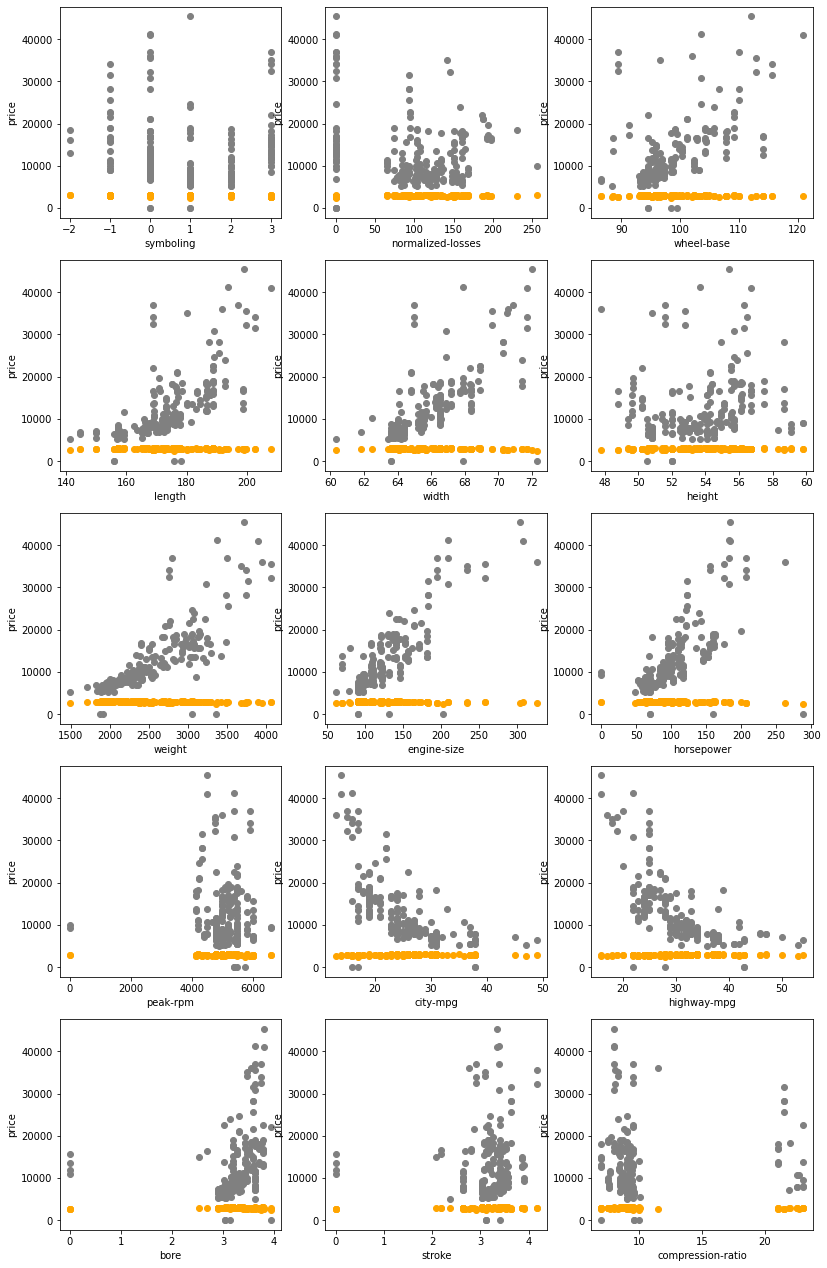

In [16]:
batch_size = 16

print(categorical_feature_names)
x_df = car_data[categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(x=x_df, y=y_series, batch_size=batch_size,
                                                    num_epochs=None, shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(x=x_df, y=y_series, batch_size=batch_size, shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(x=x_df, batch_size=batch_size, shuffle=False)

#PREPROCESSING

model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    
    for feature_name in categorical_feature_names
]
print("Model_feature_columns", model_feature_columns)

est = tf.estimator.DNNRegressor(feature_columns=model_feature_columns,
                               hidden_units=[64],
                               optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
                               )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
    est.train(train_input_fn, steps=num_training_steps // num_print_statements)
    scores = est.evaluate(eval_input_fn)
    
    print("Scores", scores)
    
scatter_plot_inference_grid(est, x_df, numeric_feature_names)

## Task 4:  Using all the features

['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']
['num-cylinders', 'fuel-type', 'make', 'engine-location', 'num-doors', 'engine-tpe', 'aspiration', 'fuel-system', 'body-style', 'drive-wheels']
Model_feature_columns [IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='num-cylinders', vocabulary_list=('four', 'three', 'five', 'eight', 'six', 'twelve', 'two'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='fuel-type', vocabulary_list=('gas', 'diesel'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='make', vocabulary_list=('toyota', 'mercury', 'dodge', 'chevrolet', 'volkswagen', 'subaru', 'honda', 'mercedes-benz', 'porsche', 'peugot', 'saab', 'jaguar', 'nissan', 'mits

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpiukxtxfw/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1000...
INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tmpiukxtxfw/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1000...
INFO:tensorflow:loss = 992379800.0, step = 1001
INFO:tensorflow:global_step/sec: 538.456
INFO:tensorflow:loss = 619467600.0, step = 1101 (0.187 sec)
INFO:tensorflow:global_step/sec: 732.347
INFO:tensorflow:loss = 1139232100.0, step = 1201 (0.137 sec)
INFO:tensorflow:global_step/sec: 718.975
INFO:tensorflow:loss = 1101111300.0, step = 1301 (0.139 sec)
INFO:tensorflow:global_step/sec: 773.155
INFO:tensorflow:loss = 1581033000.0, step = 1401 (0.130 sec)


INFO:tensorflow:Saving checkpoints for 4000 into /tmp/tmpiukxtxfw/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 4000...
INFO:tensorflow:loss = 810391800.0, step = 4001
INFO:tensorflow:global_step/sec: 573.159
INFO:tensorflow:loss = 1257413600.0, step = 4101 (0.175 sec)
INFO:tensorflow:global_step/sec: 732.668
INFO:tensorflow:loss = 1044008600.0, step = 4201 (0.139 sec)
INFO:tensorflow:global_step/sec: 716.894
INFO:tensorflow:loss = 546943300.0, step = 4301 (0.138 sec)
INFO:tensorflow:global_step/sec: 754.67
INFO:tensorflow:loss = 638462800.0, step = 4401 (0.133 sec)
INFO:tensorflow:global_step/sec: 768.031
INFO:tensorflow:loss = 847117440.0, step = 4501 (0.129 sec)
INFO:tensorflow:global_step/sec: 762.324
INFO:tensorflow:loss = 918591040.0, step = 4601 (0.132 sec)
INFO:tensorflow:global_step/sec: 771.569
INFO:tensorflow:loss = 182582600.0, step = 4701 (0.131 sec)
INFO:tensorflow:global_step/sec: 752.971
INFO:tensorflow:loss = 703529100.0, step = 4801 

INFO:tensorflow:loss = 379143100.0, step = 7201 (0.132 sec)
INFO:tensorflow:global_step/sec: 758.678
INFO:tensorflow:loss = 456783780.0, step = 7301 (0.133 sec)
INFO:tensorflow:global_step/sec: 743.829
INFO:tensorflow:loss = 392959330.0, step = 7401 (0.133 sec)
INFO:tensorflow:global_step/sec: 747.918
INFO:tensorflow:loss = 964163260.0, step = 7501 (0.134 sec)
INFO:tensorflow:global_step/sec: 766.89
INFO:tensorflow:loss = 1022238600.0, step = 7601 (0.130 sec)
INFO:tensorflow:global_step/sec: 761.721
INFO:tensorflow:loss = 668014660.0, step = 7701 (0.132 sec)
INFO:tensorflow:global_step/sec: 756.18
INFO:tensorflow:loss = 649948300.0, step = 7801 (0.133 sec)
INFO:tensorflow:global_step/sec: 763.377
INFO:tensorflow:loss = 139023660.0, step = 7901 (0.130 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 8000...
INFO:tensorflow:Saving checkpoints for 8000 into /tmp/tmpiukxtxfw/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 8000...
I

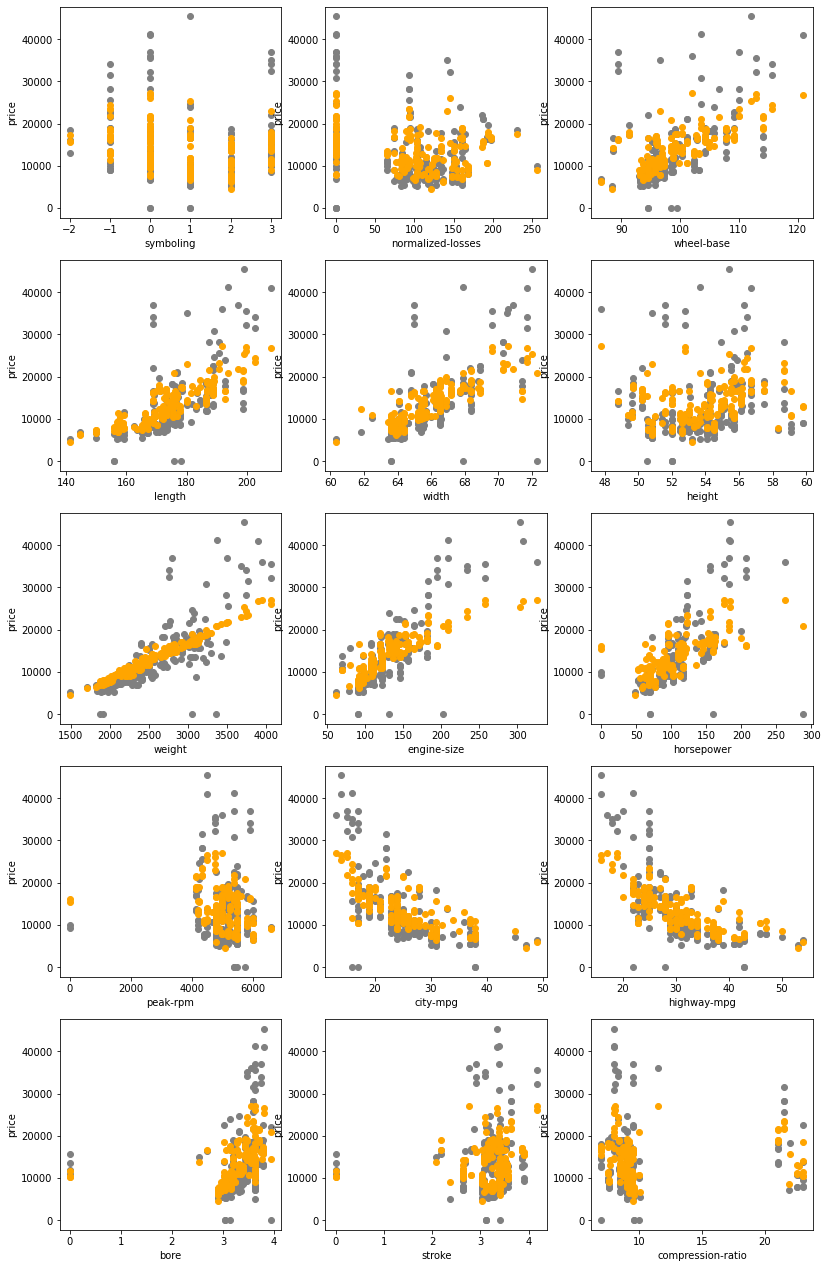

In [17]:
batch_size = 16

print(numeric_feature_names)
print(categorical_feature_names)

x_df = car_data[numeric_feature_names+categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(x=x_df, y=y_series, batch_size=batch_size,
                                                    num_epochs=None, shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(x=x_df, y=y_series, batch_size=batch_size, shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(x=x_df, batch_size=batch_size, shuffle=False)

#PREPROCESSING
# Epsilon prevents divide by zero.
epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    
    for feature_name in categorical_feature_names
] + [
    tf.feature_column.numeric_column(feature_name,
                                    normalizer_fn=lambda val: (val-x_df.mean()[feature_name])/(epsilon+x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]
print("Model_feature_columns", model_feature_columns)

est = tf.estimator.DNNRegressor(feature_columns=model_feature_columns,
                               hidden_units=[64],
                               optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
                               )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
    est.train(train_input_fn, steps=num_training_steps // num_print_statements)
    scores = est.evaluate(eval_input_fn)
    
    print("Scores", scores)
    
scatter_plot_inference_grid(est, x_df, numeric_feature_names)